## Detecting Fires and Malfunctioning Sensors

Let's build a dataflow to analyze how we can use anomaly detection and some deterministic methods to determine faulty sensors or fires.


In [1]:
import json
from datetime import datetime, timedelta, timezone
import sys
import os
from collections import defaultdict

import requests

from geopy.geocoders import Nominatim
from bytewax.dataflow import Dataflow
from bytewax.inputs import KafkaInputConfig 
from bytewax.outputs import ManualOutputConfig, StdOutputConfig
from bytewax.window import TumblingWindowConfig, EventClockConfig
from bytewax.execution import run_main

from scipy.stats import variation

from river import anomaly

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [2]:
WEBHOOK_URL = os.getenv("WEBHOOK_URL")

### Kafka Input

To start with, we are going to create our Dataflow object and then specify our input source.

For this example, since we are consuming a known, bounded stream of data, we will specify the starting offset as the beginning and the tail as false.

In [3]:
# Define Dataflow and input configuration
flow = Dataflow()
flow.input(
    "aqi_state", 
    KafkaInputConfig(
        brokers=["localhost:9092"], 
        topic="sensor_data",
        starting_offset = "beginning",
        tail = False
        )
    )

In [4]:
# Deserialize input for processing
def deserialize(key_bytes__payload_bytes):
    key_bytes, payload_bytes = key_bytes__payload_bytes
    key = json.loads(key_bytes) if key_bytes else None
    sensor_data = json.loads(payload_bytes) if payload_bytes else None
    return key, sensor_data

flow.map(deserialize)

In [5]:
# anomaly detector Class for stateful map
class AnomalyDetector:

    def __init__(self, n_trees=10, height=8, window_size=72, seed=11):
        self.detector = anomaly.HalfSpaceTrees(
                                                n_trees=n_trees,
                                                height=height,
                                                window_size=window_size,
                                                # we are using 1200 as the max for this
                                                # dataset since we know in advanced it
                                                # is the highest
                                                limits={'x': (0.0, 1200)},
                                                seed=seed
                                                )
    
    def update(self, data):
        data['score'] = self.detector.score_one({'x': float(data['PM2.5_CF1_ug/m3'])})
        self.detector.learn_one({'x': float(data['PM2.5_CF1_ug/m3'])})
        return self, data

flow.stateful_map(
    step_id = "anomaly_detector",
    builder = lambda: AnomalyDetector(n_trees=4, height=3, window_size=50, seed=11),
    mapper = AnomalyDetector.update,
)

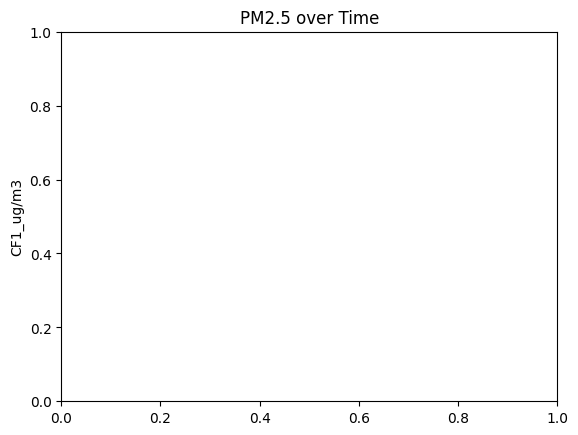

In [ ]:
class DrawPlot():
    
    def __init__(self):
        # define plot
        self.fig = plt.figure()
        self.ax = self.fig.add_subplot(1, 1, 1) 
        self.xs = defaultdict(list)
        self.ys = defaultdict(list)
        
        # Format plot
#         plt.xticks(rotation=45, ha='right')
#         plt.subplots_adjust(bottom=0.30)
        plt.title('PM2.5 over Time')
        plt.ylabel('CF1_ug/m3')

        plt.show()
    
    def plot(self, key__data):
        #plot stuff
        key, sensor_data = key__data
        # Add x and y to lists
        self.xs[key].append(sensor_data['created_at'])
        self.ys[key].append(sensor_data['PM2.5_CF1_ug/m3'])

        # Limit x and y lists to 20 items
        self.xs[key] = self.xs[key][-20:]
        self.ys[key] = self.ys[key][-20:]

        # Draw x and y lists
        self.ax.clear()
#         for _key in self.xs.keys():
        self.ax.plot([12,13,14,15], [12,13,14,15])
                

dp = DrawPlot()
flow.inspect(dp.plot)
run_main(flow)

In [7]:
# threshold filtering
flow.filter(lambda x: x[1]['score']>0.7)
flow.filter(lambda x: float(x[1]['PM2.5_CF1_ug/m3'])>50)

In [8]:
# flow.capture(StdOutputConfig())
# run_main(flow)

In [9]:
# reformat to group by region instead of by individual sensor
def groupby_region(loc__data):
    coordinates, data = loc__data
    # add the sensor location to the data payload
    data["coordinates"] = coordinates

    # Uncomment this code if you want to convert the lat, long to county automatically
    # locator = Nominatim(user_agent="myGeocoder")
    # location = locator.reverse(coordinates)
    # key = location.raw['address']['county']

    # since we know the location of these we will mark the key manually
    # as the generalized area we are interested in 
    key = "Lake Tahoe"
    return key, data

flow.map(groupby_region)

In [10]:
# setup an event-time based window to be used with `created_at` field
def get_event_time(event):
    return datetime.strptime(event["created_at"], "%Y-%m-%d %H:%M:%S %Z").replace(tzinfo=timezone.utc)

# We need to specify a wait time that is as long as the difference between
# the oldest (2022-07-01) and the newest (2022-09-18) to ensure out of order
# events are handled correctly
cc = EventClockConfig(get_event_time, wait_for_system_duration=timedelta(hours=12))

# Manually set the start time for this dataflow, this is known for this dataset 
start_at = datetime.strptime("2022-07-01 00:00:00 UTC", "%Y-%m-%d %H:%M:%S %Z").replace(tzinfo=timezone.utc)
wc = TumblingWindowConfig(start_at=start_at, length=timedelta(hours=24))

# Anomalies class to be used in the event-time window
class Anomalies:

    def __init__(self):
        self.sensors = []
        self.times = []
        self.values = []

    def update(self, event):
        self.sensors.append(event["coordinates"])
        self.times.append(event["created_at"])
        self.values.append(float(event["PM2.5_CF1_ug/m3"]))

        return self

flow.fold_window("count_sensors", cc, wc, Anomalies, Anomalies.update)

In [11]:
# Calculate some statistics and use rules to separate smoke events from malfunctions
def convert(key__anomalies):
    key, anomalies = key__anomalies
    
    # check is more than one sensor anomalous
    count_sensors = len(set(anomalies.sensors))
    count_anomalies = len(anomalies.values)
    min_event = min(anomalies.times)
    max_pm25 = max(anomalies.values)
    sensors = set(anomalies.sensors)
    malfunction = False
    anom_variance = None

    if count_sensors < 2:
        if count_anomalies < 10:
            malfunction = True
        else:
            # simplification, if there is wild variance in the data it is 
            # possibly a false positive
            anom_variance = variation(anomalies.values)
            if anom_variance > 0.3:
                malfunction = True

    return (key, {
            "sensors": sensors,
            "count_sensors": count_sensors,
            "count_anomalies": count_anomalies,
            "anomalies": anomalies.values,
            "min_event": min_event,
            "max_pm25": max_pm25,
            "variance": anom_variance,
            "malfunction": malfunction
            })

flow.map(convert)
flow.inspect(print)

In [12]:
# output smoke event data to slack channel
def output_builder(worker_index, worker_count):
    
    def send_to_slack(key__sensor_data):
        location, sensor_data = key__sensor_data
        if sensor_data['malfunction']:
            message = f'''In {location} was a malfunctioning sensor at location
                            {sensor_data['sensors']} at {sensor_data['min_event']}'''
            title = (f"Malfunctioning Sensor")
        else:
            message = f'''In {location} there is a suspected smoke event from a fire reported 
                        by sensors at {sensor_data['sensors']} at {sensor_data['min_event']}'''
            title = (f"Suspected Smoke Event")
        slack_data = {
            "username": "Air Quality Bot",
            "icon_emoji": ":satellite:",
            "channel" : "#hacking-on-bytewax",
            "attachments": [
                {
                    "color": "#9733EE",
                    "fields": [
                        {
                            "title": title,
                            "value": message,
                            "short": "false",
                        }
                    ]
                }
            ]
        }
        byte_length = str(sys.getsizeof(slack_data))
        headers = {'Content-Type': "application/json", 'Content-Length': byte_length}
        response = requests.post(WEBHOOK_URL, data=json.dumps(slack_data), headers=headers)
        if response.status_code != 200:
            raise Exception(response.status_code, response.text)

    return send_to_slack

flow.capture(
    # StdOutputConfig()
    ManualOutputConfig(output_builder)
    )

In [12]:
run_main(flow)

thread '<unnamed>' panicked at 'Box<dyn Any>', src/operators/mod.rs:61:27


UnboundLocalError: local variable 'xs' referenced before assignment